In [24]:
import os
import ot
import ot.plot
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.metrics import f1_score
from tqdm import tqdm
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN

67


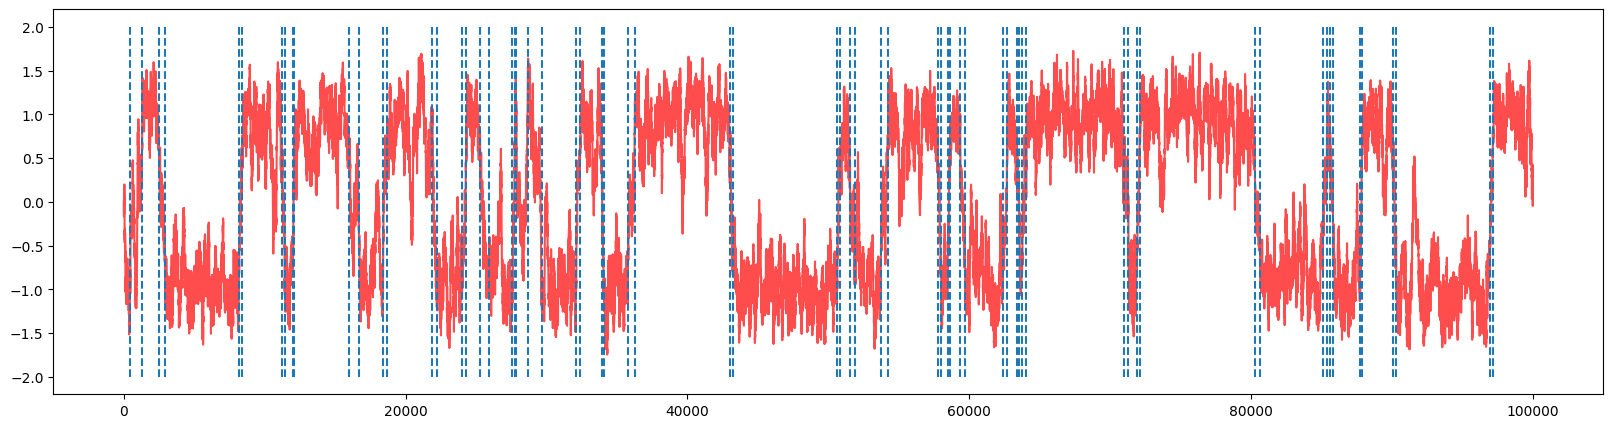

In [25]:
data = np.loadtxt("data/Langevin_1D.txt")
plt.figure(1, figsize=(20, 5))
plt.plot(np.arange(100000), data, 'r', alpha=0.7)
cp = np.loadtxt("data/ChangePts.txt")

NumPts = 100000
Points_per_bin = 100
data = data[0:NumPts]
for c in cp:
    plt.vlines(c, -2, 2, linestyle='dashed')
print(len(cp))

#plt.savefig('Plot of data.png')

In [26]:
def qW2(data, n, s):
    cpd_stat = np.zeros(len(data)// s, )
    count = 0
    for i in range(0, len(data)-s, s):
        if i<n or i>= len(data)- n:
            cpd_stat[count] = 0
        else:
            x, y = data[i-n:i], data[i: i+n]
            cpd_stat[count] = ot.emd2_1d(x, y)
        count += 1
    return cpd_stat  

def make_graph(samples, n, q):
    plt.clf()
    fig, ax = plt.subplots()
    fig.set_size_inches(24, 5)
    
    quantile = np.quantile(samples, q)
    
    peaks, _ = find_peaks(samples, height=quantile, width=0)
    
    ax.vlines(peaks*n, -2, 2, color='purple', linestyle='dashed')
    
    for c in cp:
        plt.vlines(c, -2, 2, color='g', linestyle='dashed')
    
    ax.plot(np.arange(NumPts), data, 'r', alpha=0.7)
    plt.title("Langevin Trajectory with labelled change points")

def statistic(samples, true_cp, n, s, q):
    detected_cps = qW2(samples, n, s)
    quantile = np.quantile(detected_cps, q)
    peaks, _ = find_peaks(detected_cps, height=quantile, width=0)
    TP = 0
    #Threshold set at 100pts away from true change point
    for i in peaks:
        for j in true_cp:
            if abs(i*n - j) < 100:
                TP+=1
                break
    FP = len(peaks) - TP
    FN = len(true_cp) - TP
    F1 = (2*TP)/(2*TP+FN+FP)
    return F1

45


<Figure size 640x480 with 0 Axes>

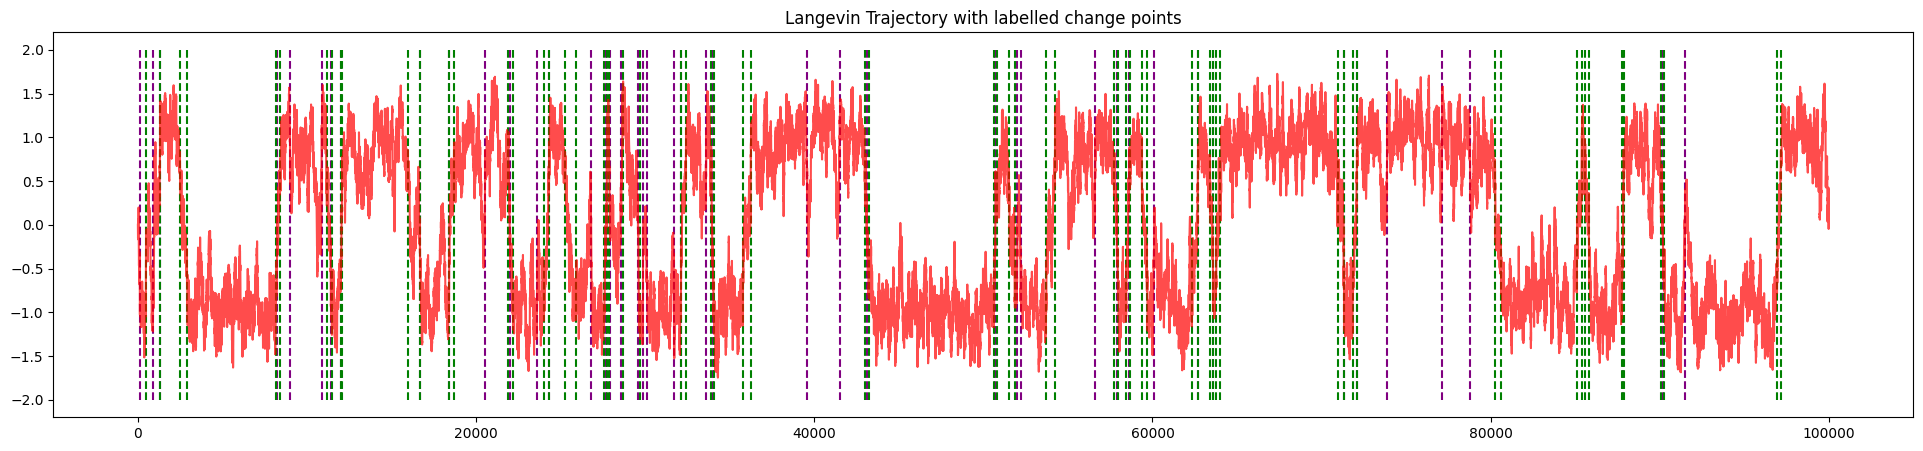

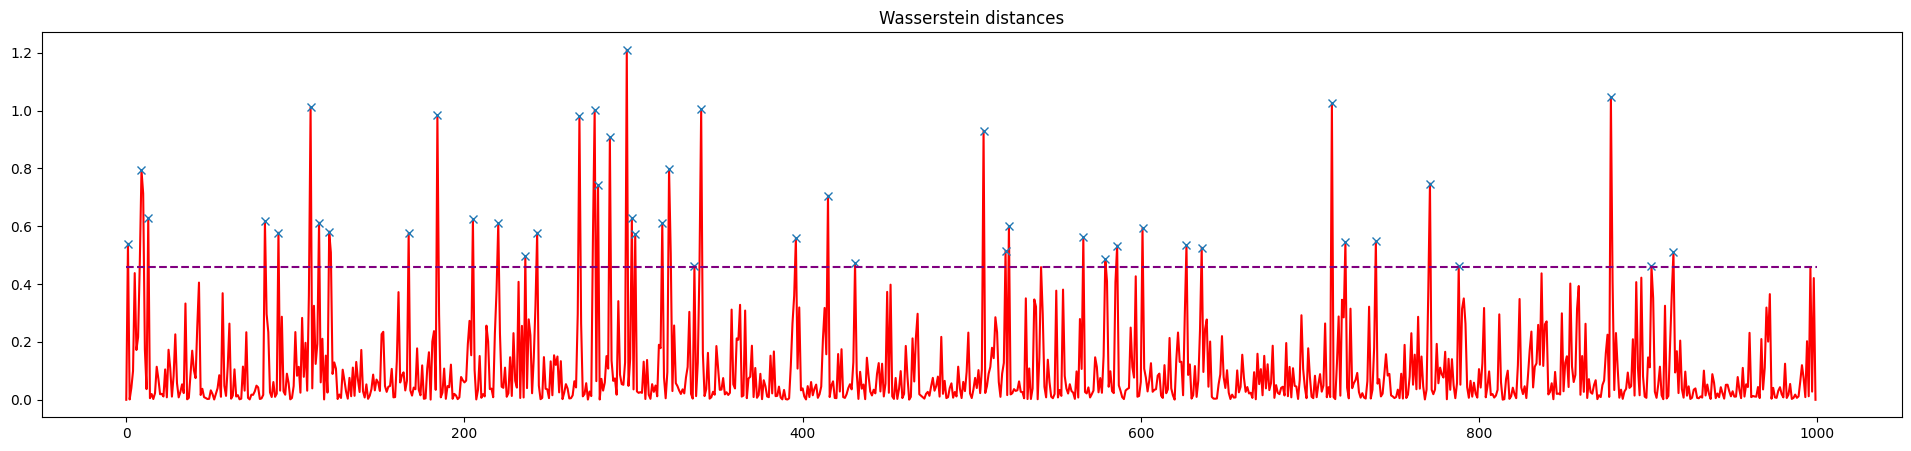

In [35]:
#Visualization of change points
cps_W2 = qW2(data, 100, 100)
make_graph(cps_W2, 100, 0.95)

fig, ax = plt.subplots()
fig.set_size_inches(24, 5)

quantile = np.quantile(cps_W2, 0.95)

peaks, _ = find_peaks(cps_W2, height=quantile, width=0)
print(len(peaks))
#ax.figure(1, figsize=(24, 5))
#NumPts/Points_per_bin
ax.plot(np.arange(1000), cps_W2, 'r')
ax.plot(peaks, cps_W2[peaks], "x")
plt.title("Wasserstein distances")

quantile_top = np.quantile(cps_W2, 0.95)
plt.hlines(quantile_top, 0, 1000, color='purple', linestyle='dashed')

# Bin size vs Quantile

In [ ]:
heatmap = []
values = []

bin_size = np.arange(10,500,1)
quantiles = np.arange(0.5, 0.99, 0.01)
    
for i in tqdm(range(0, len(bin_size))):
    for j in range(len(quantiles)):
        F1_score = statistic(data, cp, bin_size[i], bin_size[i], quantiles[j])
        values.append(F1_score)
    heatmap.append(values)
    values = []

  0%|▏                                      | 2/490 [03:33<14:29:56, 106.96s/it]

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(heatmap, index = [i for i in bin_size],
                  columns = [i for i in quantiles])

fig, ax = plt.subplots(figsize=(20,10))   

ax = sns.heatmap(df, linewidth=0.5)

plt.xlabel('quantile')
plt.ylabel('bin_size')

plt.savefig('F1 Heatmap (bin size vs quantile).png')
np.savetxt("F1 Heatmap (bin size vs quantile).txt",cp,delimiter=',');

In [37]:
import plotly.express as px
import pandas as pd

index = [str(i) for i in bin_size]
columns = [i for i in quantiles]
df = pd.DataFrame(heatmap)

fig = px.imshow(df,
                labels=dict(x="quantile", y="bin size", color="F1 Score"),
                x=columns,
                y=index)

fig.update_xaxes(side="bottom")
fig.write_html('heatmap (bin size vs quantile).html', auto_open=True)

# Bin size vs Sliding Window length

In [ ]:
bin_size = np.arange(10,500,1)
slidingwindow = np.arange(0,110,5)
slidingwindow[0] = 1
heatmap_BS_SW = []
values = []

for i in tqdm(range(0, len(bin_size))):
    for j in range(len(slidingwindow)):
        if(j > i):
            values.append(0)
        else:
            F1_score = statistic(data, cp, bin_size[i], slidingwindow[j], 0.85)
            values.append(F1_score)
    heatmap_BS_SW.append(values)
    values = []

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(heatmap_BS_SW, index = [i for i in bin_size],
                  columns = [i for i in slidingwindow])

fig, ax = plt.subplots(figsize=(20,10))   

ax = sns.heatmap(df, linewidth=0.5)

plt.xlabel('sliding window size')
plt.ylabel('bin size')

plt.savefig('F1 Heatmap (bin size vs sliding window).png')
np.savetxt("F1 Heatmap (bin size vs sliding window with quantile at 0.85).txt",cp,delimiter=',');

In [12]:
import plotly.express as px
import pandas as pd

index = [str(i) for i in bin_size]
columns = [i for i in slidingwindow]
df = pd.DataFrame(heatmap_BS_SW)

fig = px.imshow(df,
                labels=dict(x="sliding window", y="bin size", color="F1 Score"),
                x=columns,
                y=index)

fig.update_xaxes(side="bottom")
fig.write_html('heatmap (bin size vs sliding window).html', auto_open=True)

array([  1,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

# KMeans and Spectral Clustering

67


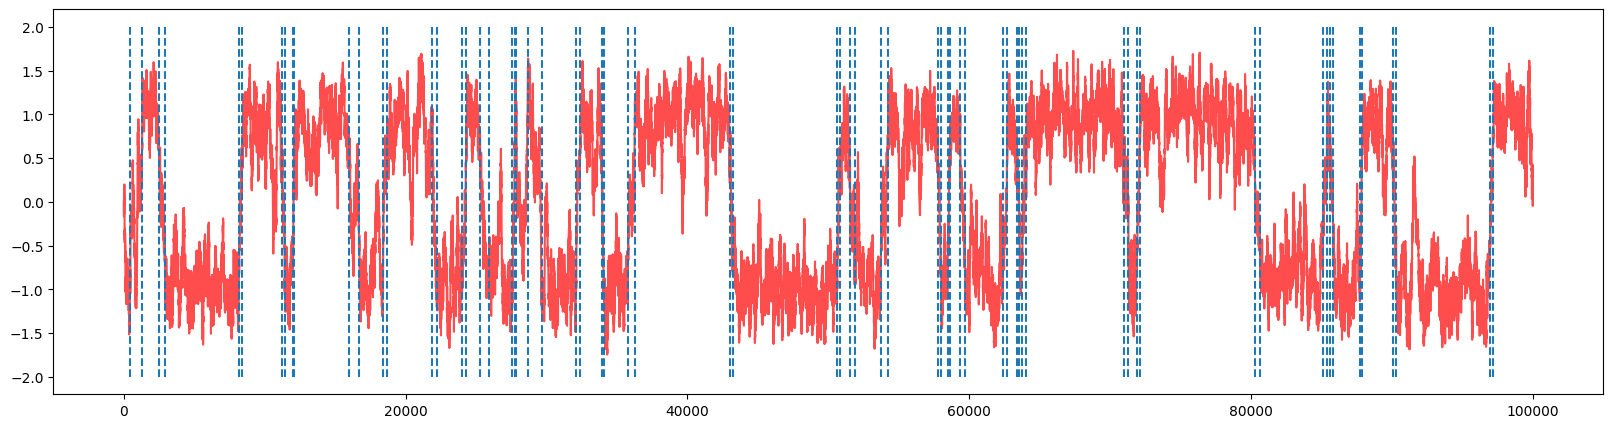

In [2]:
data = np.loadtxt("data/Langevin_1D.txt")
plt.figure(1, figsize=(20, 5))
plt.plot(np.arange(100000), data[:100000], 'r', alpha=0.7)
cp = np.loadtxt("data/ChangePts.txt")

NumPts = 100000
Points_per_bin = 100
data = data[0:NumPts]
for c in cp:
    plt.vlines(c, -2, 2, linestyle='dashed')
print(len(cp))

In [20]:
def cluster_Kmeans(bins, k):
    Points = []
    for b in bins:
        pts = np.sort(b)
        Points.append(pts)
    X = np.array(Points)
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(X)
    
    return labels

def spectral_clustering(bins, k):
    Points = []
    for b in bins:
        pts = np.sort(b)
        Points.append(pts)
    
    X = np.array(Points)
    spec = SpectralClustering(k)
    labels = spec.fit_predict(X)
    
    return labels

def DBSCAN_clustering(bins, k):
    Points = []
    for b in bins:
        pts = np.sort(b)
        Points.append(pts)
    
    X = np.array(Points)
    cluster = DBSCAN(eps=0.5, min_samples=10).fit(X)
    
    return cluster.labels_

def get_change_points_clusters(labels, bin_size):
    cp_detected = []
    
    for i in range(1,len(labels)):
        if (labels[i-1] != labels[i]):
            cp_detected.append(i)
    
    return cp_detected  

def statistic_cluster(labels, true_cp, bin_size):
    detected = get_change_points_clusters(labels, bin_size)
    TP = 0
    #Threshold set at 100pts away from true change point
    for i in detected:
        for j in true_cp:
            if abs(i*bin_size - j) < 100:
                TP+=1
                break
    FP = len(detected) - TP
    FN = len(true_cp) - TP
    F1 = (2*TP)/(2*TP+FN+FP)
    
    return F1

In [21]:
data = np.loadtxt("data/Langevin_1D.txt")
#bin_size = np.arange(10,1000,10)
bin_size = [32, 40, 50, 80, 100, 125, 160, 200, 250, 400, 500, 1000]
F1_scores_kmeans = []
F1_scores_spectral = []
F1_scores_DBSCAN = []

for b in bin_size:
    bins = np.array_split(data, int(len(data) / b))
    kmeans_labels = cluster_Kmeans(bins, 3)
    spectral_labels = spectral_clustering(bins, 3)
    DBSCAN_labels = DBSCAN_clustering(bins,3)
    F1_k = statistic_cluster(kmeans_labels, cp, b)
    F1_spectra = statistic_cluster(spectral_labels, cp, b)
    F1_DBSCAN = statistic_cluster(DBSCAN_labels, cp, b)
    F1_scores_kmeans.append(F1_k)
    F1_scores_spectral.append(F1_spectra)
    F1_scores_DBSCAN.append(F1_DBSCAN)
    
"""
for i in range(len(labels)):
    if labels[i] == 0:
        plt.plot(np.arange(SAMPLES_PER_BIN * i,SAMPLES_PER_BIN * (i+1)), data[SAMPLES_PER_BIN * i:SAMPLES_PER_BIN * (i+1)], 'b')
    if labels[i] == 1:
        plt.plot(np.arange(SAMPLES_PER_BIN * i,SAMPLES_PER_BIN * (i+1)), data[SAMPLES_PER_BIN * i:SAMPLES_PER_BIN * (i+1)], 'orange')
    if labels[i] == 2:
        plt.plot(np.arange(SAMPLES_PER_BIN * i,SAMPLES_PER_BIN * (i+1)), data[SAMPLES_PER_BIN * i:SAMPLES_PER_BIN * (i+1)], 'g')

"""

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:374: UserWarning: Exited at iteration 2000 with accuracies 
[1.27220894e-14 9.44937778e-07 3.31992994e-06 1.22210371e-05]
not reaching the requested tolerance 1e-05.
  _, diffusion_map = lobpcg(


"\nfor i in range(len(labels)):\n    if labels[i] == 0:\n        plt.plot(np.arange(SAMPLES_PER_BIN * i,SAMPLES_PER_BIN * (i+1)), data[SAMPLES_PER_BIN * i:SAMPLES_PER_BIN * (i+1)], 'b')\n    if labels[i] == 1:\n        plt.plot(np.arange(SAMPLES_PER_BIN * i,SAMPLES_PER_BIN * (i+1)), data[SAMPLES_PER_BIN * i:SAMPLES_PER_BIN * (i+1)], 'orange')\n    if labels[i] == 2:\n        plt.plot(np.arange(SAMPLES_PER_BIN * i,SAMPLES_PER_BIN * (i+1)), data[SAMPLES_PER_BIN * i:SAMPLES_PER_BIN * (i+1)], 'g')\n\n"

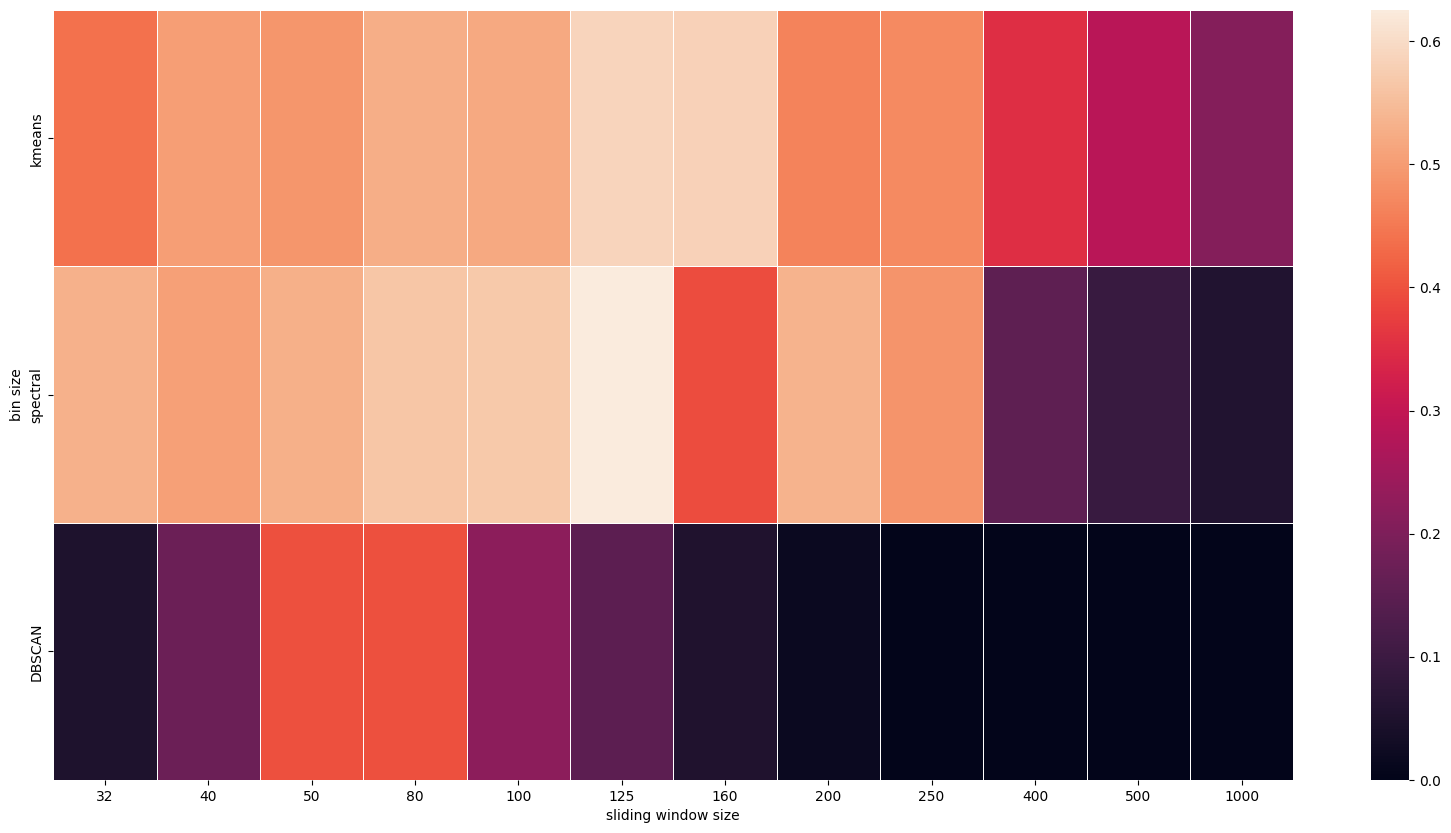

In [22]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame([F1_scores_kmeans, F1_scores_spectral, F1_scores_DBSCAN],
                  index = ["kmeans", "spectral", "DBSCAN"],
                  columns = [i for i in bin_size])

fig, ax = plt.subplots(figsize=(20,10))   

ax = sns.heatmap(df, linewidth=0.5)

plt.xlabel('sliding window size')
plt.ylabel('bin size')

plt.savefig('F1 Heatmap (bin size vs sliding window).png')

In [23]:
print(max(F1_scores_kmeans))
print(max(F1_scores_spectral))
print(max(F1_scores_DBSCAN))



0.5870646766169154
0.6256410256410256
0.39828693790149894
